In [53]:
import firedrake as fd
from tqdm.auto import tqdm, trange
from numpy.random import default_rng
import numpy as np
import matplotlib.pyplot as plt

100%|██████████| 2/2 [00:00<00:00, 370.70it/s]


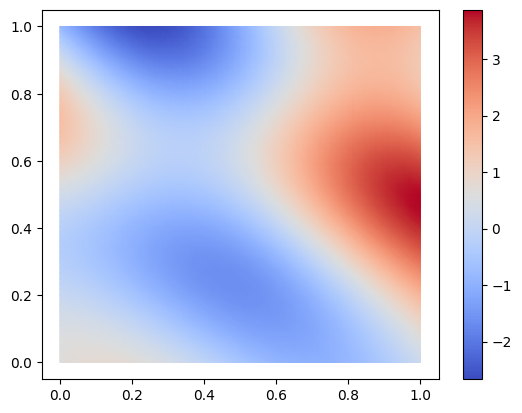

In [54]:
def random_field(V, N: int = 1, m: int = 5, σ: float = 0.6,
                 tqdm: bool = False, seed: int = 2023):
    """Generate N 2D random fields with m modes."""
    rng = default_rng(seed)
    x, y = fd.SpatialCoordinate(V.ufl_domain())
    fields = []
    for _ in trange(N, disable=not tqdm):
        r = 0
        for _ in range(m):
            a, b = rng.standard_normal(2)
            k1, k2 = rng.normal(0, σ, 2)
            θ = 2 * np.pi * (k1 * x + k2 * y)
            r += fd.Constant(a) * fd.cos(θ) + fd.Constant(b) * fd.sin(θ)
        fields.append(fd.interpolate(np.sqrt(1 / m) * r, V))
    return fields

mesh = fd.UnitSquareMesh(32, 32)
V = fd.FunctionSpace(mesh, "CG", 1)
fields = random_field(V, N=2, tqdm=True, seed=20)
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
collection = fd.tripcolor(fields[1], axes=axes, cmap='coolwarm')
fig.colorbar(collection);

## generate tensor field

In [55]:
# Random tensor field function definition
def random_tensor_field(V, N: int = 1, m: int = 5, σ: float = 0.6, tqdm: bool = False, seed: int = 2023):
    """Generate N 2D random tensor fields with m modes."""
    rng = default_rng(seed)
    x, y = fd.SpatialCoordinate(V.mesh())

    fields = []
    for _ in trange(N, disable=not tqdm):
        tensor_components = [[], [], []]
        for i in range(3):
            r = 0
            for _ in range(m):
                a, b = rng.standard_normal(2)
                k1, k2 = rng.normal(0, σ, 2)
                θ = 2 * np.pi * (k1 * x + k2 * y)
                r += fd.Constant(a) * fd.cos(θ) + fd.Constant(b) * fd.sin(θ)
            r_val = np.sqrt(1./m) * r
            tensor_components[i] = r_val
        tensor_field = fd.as_tensor([[tensor_components[0], tensor_components[1]], [tensor_components[1], tensor_components[2]]])
        fields.append(fd.interpolate(tensor_field, V))
    return fields

# Create a mesh and a TensorFunctionSpace
mesh = fd.UnitSquareMesh(32, 32)
V = fd.TensorFunctionSpace(mesh, "CG", 1)

# Generate random tensor fields
tensor_fields = random_tensor_field(V, N=2, tqdm=True, seed=20)

100%|██████████| 2/2 [00:00<00:00, 155.85it/s]


In [27]:
tensor_fields

[Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f540ae70220>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 371)), 140),
 Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f540ae70220>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 371)), 145)]

In [28]:
tensor_fields[0]

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f540ae70220>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 371)), 140)

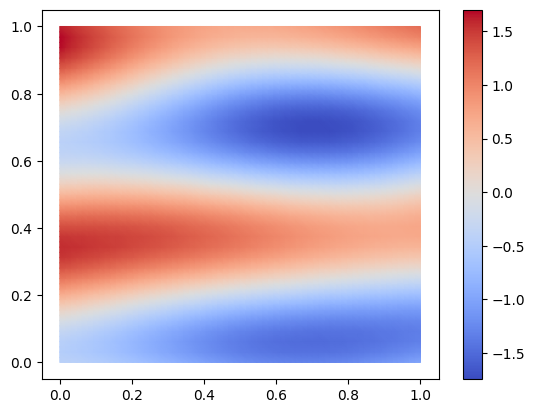

In [56]:
scalar_data = tensor_fields[1].dat.data[:, 0, 0]
# Create a new scalar Function to hold the data
scalar_function = fd.Function(fd.FunctionSpace(mesh, "CG", 1))
scalar_function.dat.data[:] = scalar_data
# Now you can use tripcolor to plot this scalar function
fig, axes = plt.subplots()
collection = fd.tripcolor(scalar_function, axes=axes, cmap='coolwarm')
fig.colorbar(collection)
plt.show()

In [30]:
tensor_fields[0].dat.data

array([[[-0.44040667,  0.64099698],
        [ 0.64099698, -0.10357319]],

       [[-0.34249163,  0.62868613],
        [ 0.62868613, -0.45551932]],

       [[-0.25964421,  0.7066767 ],
        [ 0.7066767 , -0.00912176]],

       ...,

       [[ 0.01974311,  1.39752516],
        [ 1.39752516, -2.02376824]],

       [[-0.05273883,  1.6667174 ],
        [ 1.6667174 , -1.9762833 ]],

       [[ 0.0929542 ,  1.5090549 ],
        [ 1.5090549 , -1.97637665]]])

In [31]:
tensor_fields[0].dat.data[1]

array([[-0.34249163,  0.62868613],
       [ 0.62868613, -0.45551932]])

In [32]:
tensor_fields[0][0,0]

Indexed(Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f540ae70220>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 371)), 140), MultiIndex((FixedIndex(0), FixedIndex(0))))

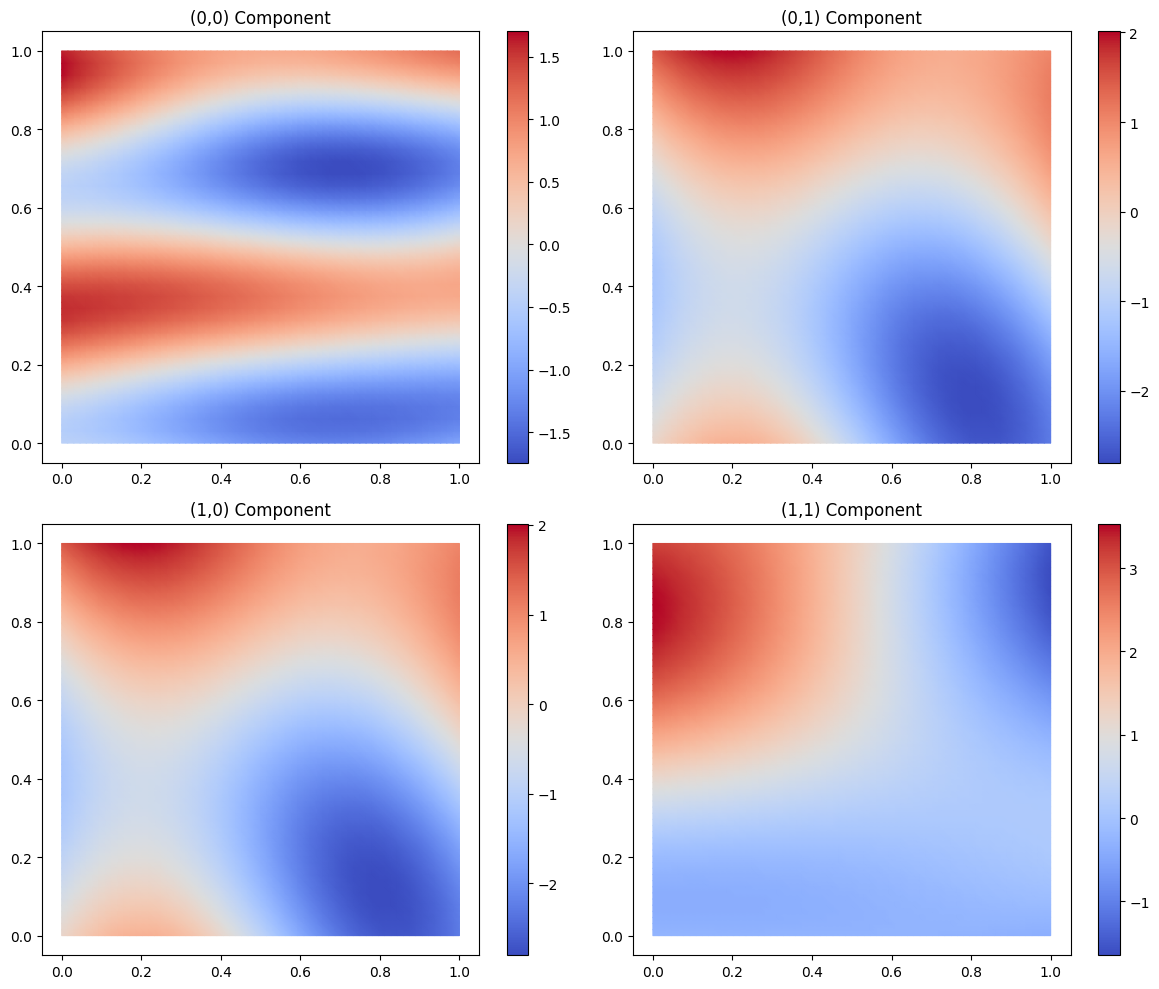

<Figure size 600x500 with 0 Axes>

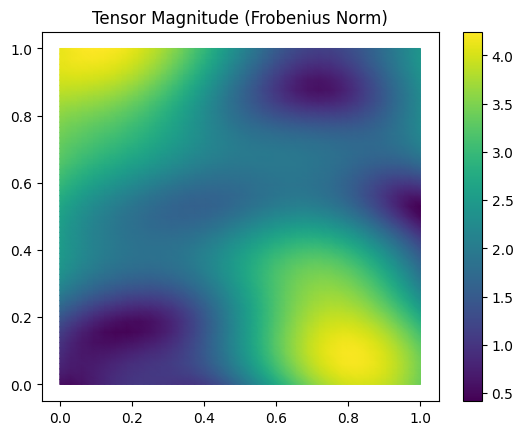

In [57]:
import firedrake as fd
import numpy as np

# ... (All your previous code including tensor field function definition)

# Given tensor field data, create scalar functions for the components and magnitude
def create_scalar_functions_from_tensor(tensor_field, mesh):
    components = [(0, 0), (0, 1), (1, 0), (1, 1)]
    scalar_functions = []

    for (i, j) in components:
        scalar_data = tensor_field.dat.data[:, i, j]
        scalar_function = fd.Function(fd.FunctionSpace(mesh, "CG", 1))
        scalar_function.dat.data[:] = scalar_data
        scalar_functions.append(scalar_function)

    magnitude_data = np.sqrt(np.sum(tensor_field.dat.data**2, axis=(1, 2)))
    magnitude_function = fd.Function(fd.FunctionSpace(mesh, "CG", 1))
    magnitude_function.dat.data[:] = magnitude_data

    return scalar_functions, magnitude_function

# Visualize the scalar functions
def visualize_scalar_functions(scalar_functions, magnitude_function):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    titles = ["(0,0) Component", "(0,1) Component", "(1,0) Component", "(1,1) Component"]

    for ax, scalar_fn, title in zip(axs.ravel(), scalar_functions, titles):
        collection = fd.tripcolor(scalar_fn, axes=ax, cmap='coolwarm')
        ax.set_title(title)
        fig.colorbar(collection, ax=ax)

    plt.tight_layout()
    plt.show()

    # Visualize the magnitude
    plt.figure(figsize=(6, 5))
    collection = fd.tripcolor(magnitude_function, cmap='viridis')
    plt.colorbar(collection)
    plt.title("Tensor Magnitude (Frobenius Norm)")
    plt.show()

scalar_fns, magnitude_fn = create_scalar_functions_from_tensor(tensor_fields[1], mesh)
visualize_scalar_functions(scalar_fns, magnitude_fn)


In [58]:
E = 210e9
nu = 0.3

def forward(E, nu, strain_tensor):
    ## define displacement 
    V_vector = fd.VectorFunctionSpace(mesh, 'CG', 1)
    V_tensor = fd.TensorFunctionSpace(mesh, 'CG', 1)
    u = fd.TrialFunction(V_vector)
    v = fd.TestFunction(V_vector)
    u_sol = fd.Function(V_vector)
    
    mu = E/(2*(1+nu))
    lmbda = E*nu/((1+nu)*(1-2*nu))

    def epsilon(u):
        return fd.sym(fd.grad(u))
        # return 0.5*(fd.grad(u) + fd.grad(u.T))
    def sigma(u):
        return lmbda*fd.tr(epsilon(u))*fd.Identity(2) + 2*mu*epsilon(u)
    # Body force
    f = fd.Constant((0.0, 0.0))
    
    exx, eyy, exy = strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]
    x,y = fd.SpatialCoordinate(mesh)
    uLx = - exx/2 + exy * (y-.5)
    uLy = eyy * (y-.5) - exy/2
    uRx = exx/2 + exy * (y-.5)
    uRy = eyy * (y-.5) + exy/2
    
    uBx = exx * (x-.5) - exy/2
    uBy = - eyy/2 + exy * (x-.5)
    uTx = exx * (x-.5) + exy/2
    uTy = eyy/2 + exy * (x-.5)
    
    bcL = fd.DirichletBC(V_vector, [uLx, uLy], 1)
    bcR = fd.DirichletBC(V_vector, [uRx, uRy], 2)
    bcB = fd.DirichletBC(V_vector, [uBx, uBy], 3)
    bcT = fd.DirichletBC(V_vector, [uTx, uTy], 4)
    
    # Define the weak form
    a = fd.inner(sigma(u), epsilon(v)) * fd.dx 
    # +inner(sigma(u_) * n, v) * ds(1) - inner(sigma(u_) * n, v) * ds(2) + inner(sigma(u_) * n, v) * ds(3) - inner(sigma(u_) * n, v) * ds(4) 
    L = fd.inner(f, v) * fd.dx
    
    fd.solve(a == L, u_sol,bcs=[bcL, bcB, bcR, bcT])
    
    V_tensor = fd.TensorFunctionSpace(mesh, 'CG', 1)
    sig = fd.project(sigma(u_sol), V_tensor)
    # print('sig',sig.dat.data)
    
    return fd.project(sigma(u_sol), V_tensor)

stress_field = forward(E, nu, tensor_fields[0])

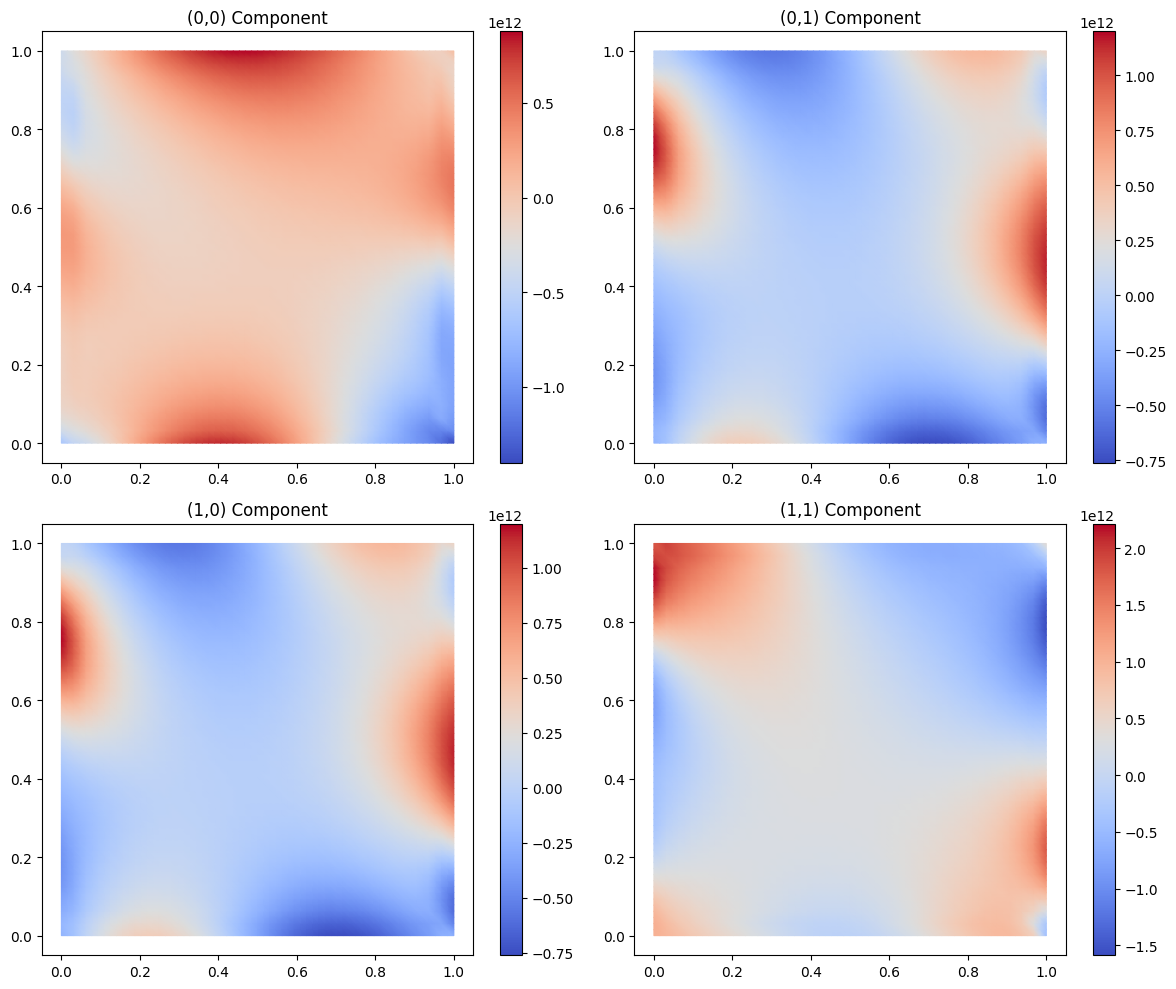

<Figure size 600x500 with 0 Axes>

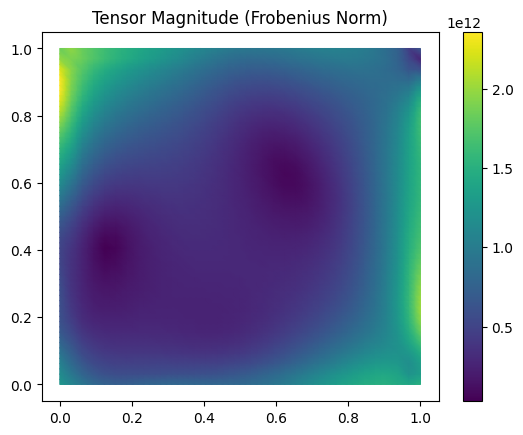

In [59]:
scalar_fns, magnitude_fn = create_scalar_functions_from_tensor(stress_field, mesh)
visualize_scalar_functions(scalar_fns, magnitude_fn)

In [39]:
def forward(E, nu, strain_tensor):
    # Directly work with the strain tensor field (Firedrake tensor function)
    epsilon_xx = strain_tensor[0, 0]
    epsilon_yy = strain_tensor[1, 1]
    epsilon_xy = strain_tensor[0, 1]
    
    # Compute stress tensor components using linear elasticity relationships
    # Here, all operations are carried out on UFL expressions
    sigma_xx = E / (1 - nu**2) * (epsilon_xx + nu * epsilon_yy)
    sigma_yy = E / (1 - nu**2) * (epsilon_yy + nu * epsilon_xx)
    sigma_xy = E / (2*(1 + nu)) * epsilon_xy
    
    # Assemble stress tensor in Firedrake format
    stress_tensor = fd.as_tensor([[sigma_xx, sigma_xy], [sigma_xy, sigma_yy]])
    
    return stress_tensor

# Now, assuming you've generated tensor_fields using your random_tensor_field function:
E = 210e9
nu = 0.3
stress_fields = forward(E, nu, tensor_fields[0])

stress_fields[0]


ListTensor(Product(FloatValue(230769230769.23077), Sum(Indexed(Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f540ae70220>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 371)), 140), MultiIndex((FixedIndex(0), FixedIndex(0)))), Product(FloatValue(0.3), Indexed(Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f540ae70220>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 371)), 140), MultiIndex((FixedIndex(1), FixedIndex(1))))))), Product(FloatValue(80769230769.23077), Indexed(Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f540ae70220>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lag

In [14]:
V_scalar = fd.FunctionSpace(mesh, 'CG', 1)
sigma_xx = fd.project(stress_fields[0][1], V_scalar)
V_tensor = fd.TensorFunctionSpace(mesh, 'CG', 1)
sigma = fd.project(stress_fields, V_tensor)
sigma

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f542f249160>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 25)), 79)

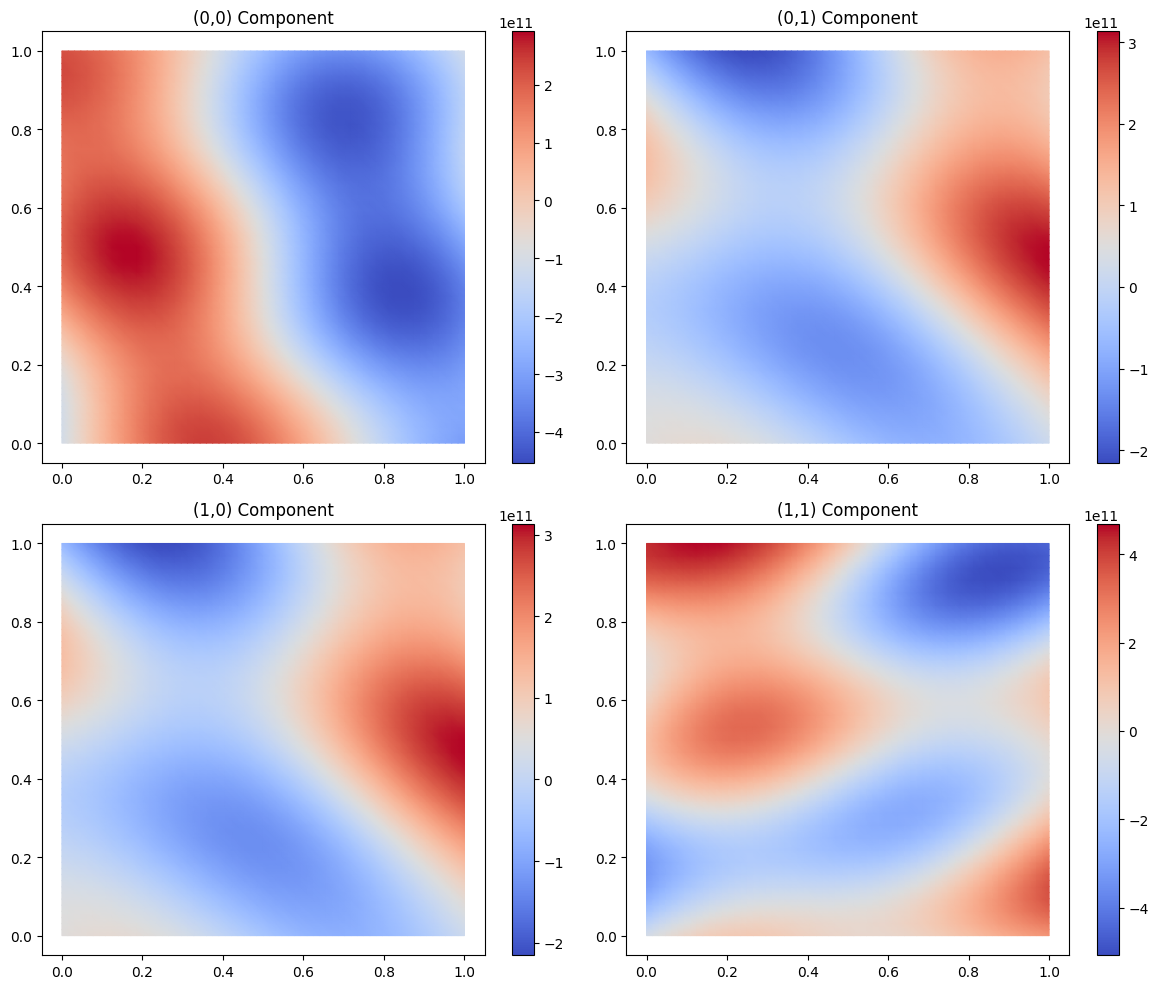

<Figure size 600x500 with 0 Axes>

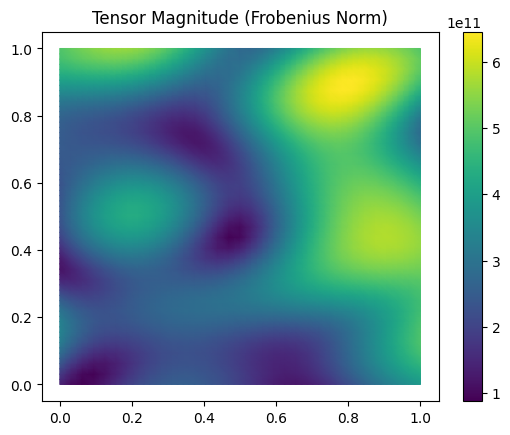

In [15]:
scalar_fns, magnitude_fn = create_scalar_functions_from_tensor(sigma, mesh)
visualize_scalar_functions(scalar_fns, magnitude_fn)

In [60]:
tensor_fields[0]

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x15805e250>, TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 27342)), 139909)

In [17]:
# def forward(E, nu, strain_tensor):
#     mu = E/(2*(1+nu))
#     lmbda = E*nu/((1+nu)*(1-2*nu))
    
#     strain_data = strain_tensor.dat.data
#     stress_data = []
#     for epsilon in strain_data:
#         stress_theory = lmbda * np.trace(epsilon) * np.eye(2) + 2 * mu * epsilon
#         stress_data.append(stress_theory)
    
#     # Create a new Firedrake tensor function to store the stress tensor
#     V = strain_tensor.function_space()
#     stress_field = fd.Function(V)
#     stress_field.dat.data[:] = stress_data
#     return stress_field

# stress_fields = forward(E, nu, tensor_fields[0])

In [18]:
# scalar_fns, magnitude_fn = create_scalar_functions_from_tensor(stress_fields, mesh)
# visualize_scalar_functions(scalar_fns, magnitude_fn)

In [61]:
class Normalizer:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        """Compute the mean and std deviation of the data."""
        self.mean = data.mean()
        self.std = data.std()

    def transform(self, data):
        """Normalize the data using z-score normalization."""
        if self.mean is None or self.std is None:
            raise ValueError("Normalizer must be fit before calling transform.")
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        """Revert the normalized data to its original form."""
        if self.mean is None or self.std is None:
            raise ValueError("Normalizer must be fit before calling inverse_transform.")
        return data * self.std + self.mean


In [62]:
from typing import Union, Callable
import os
import h5py

def generate_data(V, dataset_dir: str, E, nu, ntrain: int = 50, ntest: int = 10,
                  noise: Union[str, Callable] = "normal",
                  scale_noise: float = 0, seed: int = 1234):
    print("\n Generate random fields")
    print("\n Generate corresponding PDE solutions")
    
    # Generate random tensor fields
    stress_tensor_fields = []
    strain_tensor_fields = random_tensor_field(V, N=ntrain+ntest, tqdm=True, seed=20)
    # normailze strain tensor fields
    strain_normalizer = Normalizer()
    stress_normalizer = Normalizer()
    # Fit the normalizer on training strain data
    all_strains = np.concatenate([tensor.dat.data for tensor in strain_tensor_fields[:ntrain]])
    strain_normalizer.fit(all_strains)
    # Normalize all strain data
    for tensor in strain_tensor_fields:
        tensor.dat.data[:] = strain_normalizer.transform(tensor.dat.data)
    
    
    ## generate stress tensor fields
    for i in range(ntrain+ntest):
        V_tensor = fd.TensorFunctionSpace(mesh, "CG", 1)
        stress_field = forward(E, nu, strain_tensor_fields[i])
        stress_field = fd.project(stress_field, V_tensor)
        stress_tensor_fields.append(stress_field)
    
    # Fit the stress_normalizer on training stress data
    all_stresses = np.concatenate([tensor.dat.data for tensor in stress_tensor_fields[:ntrain]])
    stress_normalizer.fit(all_stresses)
    
    # Normalize all stress data
    for tensor in stress_tensor_fields:
        tensor.dat.data[:] = stress_normalizer.transform(tensor.dat.data)
    
    # Add noise to tensor fields if required
    if noise == "normal":
        stress_obs = []
        for tensor in stress_tensor_fields:
            tensor_obs = fd.Function(V_tensor).assign(tensor)
            
            # Generate noise matrix for each data point
            noise_matrix = scale_noise * np.random.rand(*tensor_obs.dat.data.shape)
            
            # Add noise to tensor data
            tensor_obs.dat.data[:] += noise_matrix
            stress_obs.append(tensor_obs)
            
    print("\n Generated ", ntrain, " training samples and ",ntest, "test samples.")
    stress_obs_train, stress_obs_test = stress_obs[:ntrain], stress_obs[ntrain:]
    stress_train, stress_test = stress_tensor_fields[:ntrain], stress_tensor_fields[ntrain:]
    strain_train, strain_test = strain_tensor_fields[:ntrain], strain_tensor_fields[ntrain:]
    
     
    print("\nSave train/test data to", dataset_dir)
    with fd.CheckpointFile(os.path.join(dataset_dir, "train_data.h5"), "w") as afile:
        afile.h5pyfile["n"] = ntrain
        afile.save_mesh(mesh)
        for i in range(ntrain):
            afile.save_function(strain_train[i],idx=i, name="k")
            afile.save_function(stress_train[i],idx=i, name="u_obs")
            afile.save_function(stress_obs_train[i],idx=i, name="u_obs_noisy")
        
    with fd.CheckpointFile(os.path.join(dataset_dir, "test_data.h5"), "w") as afile:
        afile.h5pyfile["n"] = ntest
        afile.save_mesh(mesh)
        for i in range(ntest):
            afile.save_function(strain_test[i],idx=i, name="k")
            afile.save_function(stress_test[i],idx=i, name="u_obs")
            afile.save_function(stress_obs_test[i],idx=i, name="u_obs_noisy")

      

In [64]:
ntrain = 500
ntest = 50

noise = "normal"
scale_noise = 1

nx = 32
ny = 32
Lx = 1
Ly = 1

E = 210e9
nu = 0.3

degree = 1
data_dir = "data/datasets/solvepde"
dataset_name = "linear_equation"
seed = 12

mesh = fd.RectangleMesh(nx, ny, Lx, Ly, name="mesh")
V_tensor = fd.TensorFunctionSpace(mesh, "CG", degree)

generate_data(V_tensor, data_dir, E, nu, ntrain, ntest, noise, scale_noise, seed)


 Generate random fields

 Generate corresponding PDE solutions


  0%|          | 0/550 [00:00<?, ?it/s]

100%|██████████| 550/550 [00:02<00:00, 239.64it/s]



 Generated  500  training samples and  50 test samples.

Save train/test data to data/datasets/solvepde
